In [68]:
# Dependencies
## !pip install tensorflow opencv-python matplotlib

In [ ]:
!pip list

In [70]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

# Data Setup

In [3]:
data_dir = 'data/train'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [4]:
# Check all covid pictures
# os.listdir(os.path.join(data_dir, 'covid'))

In [113]:
img = cv2.imread(os.path.join('data/train', 'covid', '02.jpeg'))
img.shape

(3480, 4248, 3)

In [ ]:
# Image is 3480 pixels high x 4248 pixels wide with 3 channels (colored image

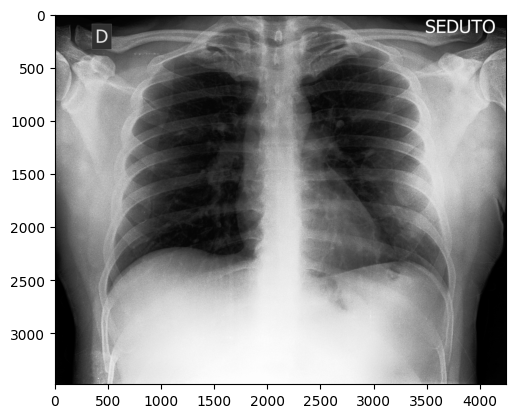

In [114]:
plt.imshow(cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE))
plt.imshow(img, cmap='gray_r')
plt.show()

In [46]:
## Remove any incompatible image extensions (in case dataset is extracted from Google search)
# for image_class in os.listdir(data_dir):
#     for image in os.listdir(os.path.join(data_dir, image_class)):
#         image_path = os.path.join(data_dir, image_class, image)
#         try:
#             img = cv2.imread(image_path)
#             tip = imghdr.what(image_path)
#             if tip not in image_exts:
#                 print('Image not in ext list {}'.format(image_path))
#                 os.remove(image_path)
#         except Exception as e:
#             print('Issue with image {}'.format(image_path))

# Load Data

In [39]:
# Build dataset with classes on the fly with Keras
train_data = tf.keras.utils.image_dataset_from_directory('data/train')

Found 181 files belonging to 2 classes.


In [40]:
train_data_iterator = train_data.as_numpy_iterator()

In [41]:
train_batch = train_data_iterator.next()

In [20]:
test_data = tf.keras.utils.image_dataset_from_directory('data/test')

Found 46 files belonging to 2 classes.


In [21]:
test_data_iterator = test_data.as_numpy_iterator()

In [22]:
test_batch = test_data_iterator.next()

### Dataset Info

In [27]:
print("There's %s parts of the data. The image representation (as numpy arrays) and the label." % (len(train_batch)))

There's 2 parts of the data. The image representation (as numpy arrays) and the label.


In [28]:
train_batch[0].shape
# 32 loaded images; 256x256 pixels (image_size on tf.keras.utils.image_dataset_from_directory); 3 color channels

(32, 256, 256, 3)

In [29]:
train_batch[1]
# Image labels

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1])

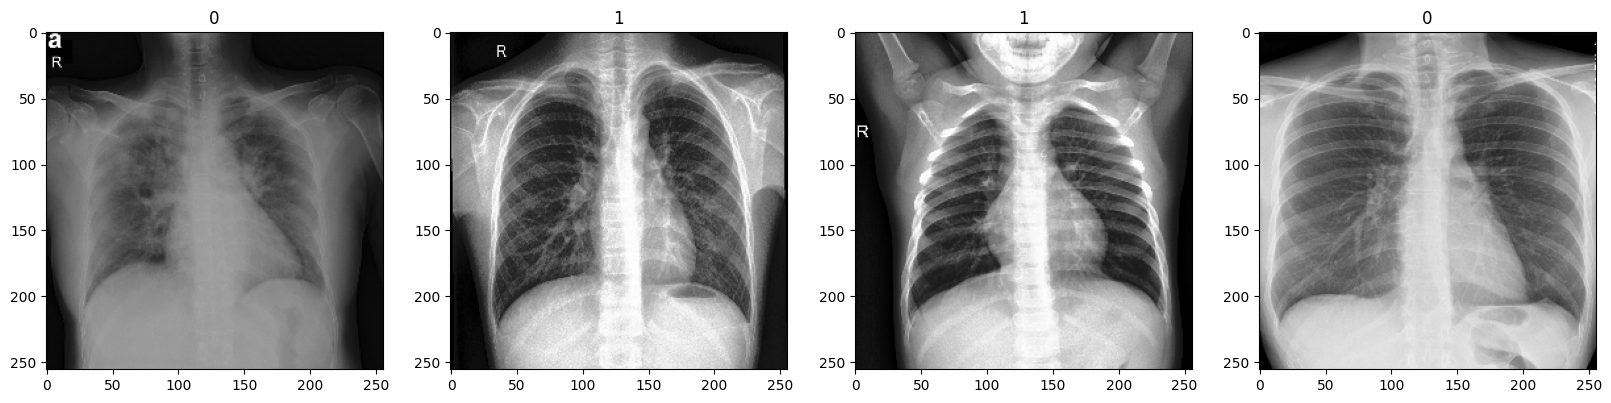

In [44]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(train_batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(train_batch[1][idx])

In [31]:
# Class 1 is assigned to normal lung X-Rays and Class 0 to COVID-infected lungs X-Rays.

# Pre-process Data

## Scaling
Each of the 3 color chanels (RGB) uses 8-bits channels to represent pixel intensity levels. The 8-bit color channel can represent 256  different intensity levels (2^8; 2 for combinations of 0 or 1 and 8 for the 8-bit channel), ranging from 0 (minimum intensity, interpreted as black) to 255 (maximum intensity, interpreted as white). Scaling allows the pixel value to go from [0, 255] to [0,1] improves ML performance by increasing numerical stability, uniformity and compatability for algorithms designed to work with such limits.

In [45]:
# Applying scaling to X as X is images and y is labels.
train_data = train_data.map(lambda x, y: (x/255, y))
test_data = test_data.map(lambda x, y: (x/255, y))

In [60]:
train_data.as_numpy_iterator().next()[0].max()

1.0

## Split Data
Because we already have a testing dataset, we can skip splitting into test and train data and build a validation dataset.

In [66]:
print("Training dataset has %s batches" %(len(train_data)))

Training dataset has 6 batches


In [67]:
print("Testing dataset has %s batches" %(len(test_data)))

Testing dataset has 2 batches


In [71]:
# Build validation dataset from the training dataset by allocating 2 batches for the validation partition
train_size = len(train_data)
validation_size = 2

val_data = train_data.take(validation_size)
train_data = train_data.skip(validation_size)

# Deep Learning Model

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [74]:
model = Sequential()

In [ ]:
# Input layer with 16 filters of 3x3 pixels size and 1 pixel of stride
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [77]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [78]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 32)       

## Train

In [79]:
logdir = 'logs'

In [80]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [82]:
hist = model.fit(train_data, epochs=20, validation_data=val_data, callbacks= [tensorboard_callback])

Epoch 1/20


4/4 [==============================] - 32s 7s/step - loss: 1.1029 - accuracy: 0.5812 - val_loss: 1.7142 - val_accuracy: 0.5625
Epoch 2/20
4/4 [==============================] - 5s 1s/step - loss: 0.9977 - accuracy: 0.6838 - val_loss: 0.5385 - val_accuracy: 0.5312
Epoch 3/20
4/4 [==============================] - 5s 1s/step - loss: 0.5058 - accuracy: 0.7179 - val_loss: 0.3408 - val_accuracy: 0.8594
Epoch 4/20
4/4 [==============================] - 5s 1s/step - loss: 0.3259 - accuracy: 0.9402 - val_loss: 0.2586 - val_accuracy: 0.9844
Epoch 5/20
4/4 [==============================] - 6s 1s/step - loss: 0.1774 - accuracy: 0.9915 - val_loss: 0.0915 - val_accuracy: 1.0000
Epoch 6/20
4/4 [==============================] - 6s 1s/step - loss: 0.0668 - accuracy: 0.9915 - val_loss: 0.0699 - val_accuracy: 0.9531
Epoch 7/20
4/4 [==============================] - 6s 1s/step - loss: 0.0592 - accuracy: 0.9744 - val_loss: 0.1615 - val_accuracy: 0.9062
Epoch 8/20
4/4 [======================

## Performance Plot

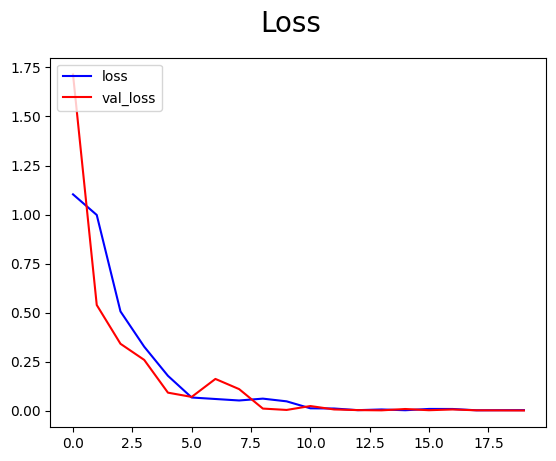

In [83]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='blue', label='loss')
plt.plot(hist.history['val_loss'], color='red', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

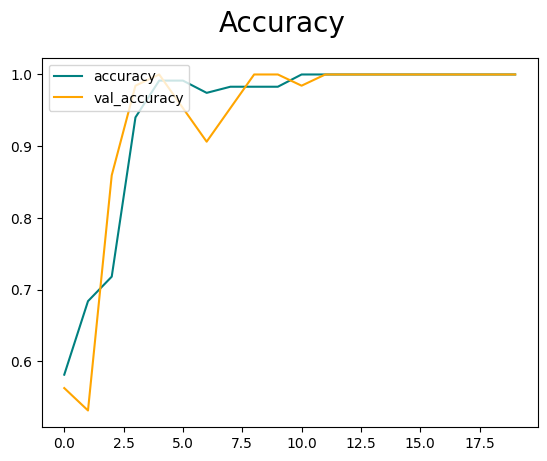

In [84]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Evaluate Performance

In [86]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [87]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [88]:
len(test_data)

2

In [89]:
for batch in test_data.as_numpy_iterator():
    x, y_true = batch
    y_pred = model.predict(x)
    precision.update_state(y_true, y_pred)
    recall.update_state(y_true, y_pred)
    accuracy.update_state(y_true, y_pred)

1/1 [==============================] - 1s 671ms/step


In [92]:
print('Precision: %f, Recall: %f, Accuracy: %f' % (precision.result(), recall.result(), accuracy.result()))

Precision: 1.000000, Recall: 1.000000, Accuracy: 1.000000


In [94]:
# Perfect accuracy can be a sign of overfitting.

## Test with new cases

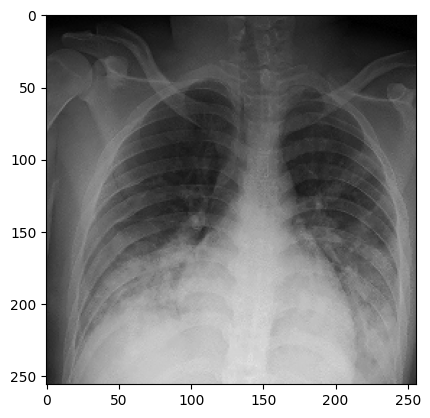

In [125]:
covid_img = cv2.imread('data/test/covid_test_boston.jpeg')
covid_resize = tf.image.resize(covid_img, (256,256))
plt.imshow(covid_resize.numpy().astype(int))
plt.show()

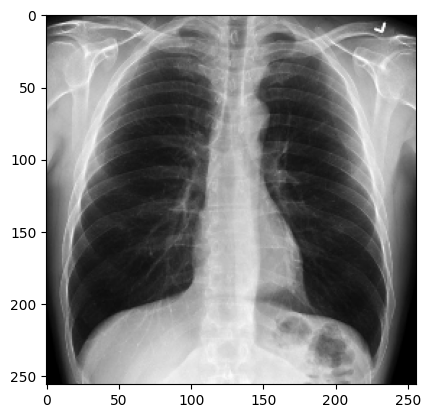

In [127]:
normal_img = cv2.imread('data/test/radiopedia_normal.jpg')
normal_resize = tf.image.resize(normal_img, (256,256))
plt.imshow(normal_resize.numpy().astype(int))
plt.show()

In [130]:
y_pred_cov = model.predict(np.expand_dims(covid_resize/255, 0))

1/1 [==============================] - 0s 440ms/step


In [139]:
# Class 1 is assigned to normal lung X-Rays and Class 0 to COVID-infected lungs X-Rays. 0.5 is our cut-off point, due to the use of sigmoid layer.

In [137]:
if y_pred_cov < 0.5:
    print(f'Predicted Class: COVID-19 infected lungs.')
else:
    print(f'Predicted Class: Normal Lungs.')

Predicted Class: COVID-19 infected lungs.


In [133]:
y_pred_nom = model.predict(np.expand_dims(normal_resize/255, 0))

1/1 [==============================] - 0s 98ms/step


In [138]:
if y_pred_nom < 0.5:
    print(f'Predicted Class: COVID-19 infected lungs.')
else:
    print(f'Predicted Class: Normal Lungs.')

Predicted Class: Normal Lungs.


# Save the model

In [140]:
from tensorflow.keras.models import load_model

In [142]:
model.save(os.path.join('models', 'covid19_xray_detection_model.h5'))

## Test Loaded Model

In [143]:
loaded_model = load_model(os.path.join('models', 'covid19_xray_detection_model.h5'))

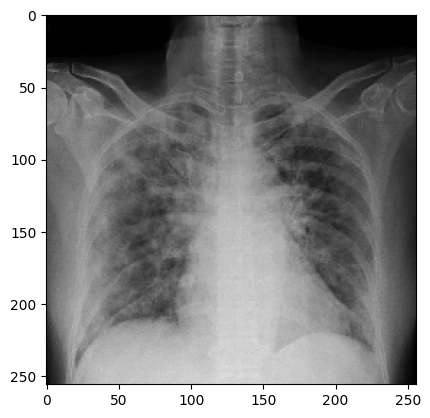

In [149]:
covid_princ = cv2.imread('data/test/princeton_covid.jpg')
covid_princ_resize = tf.image.resize(covid_princ, (256,256))
plt.imshow(covid_princ_resize.numpy().astype(int))
plt.show()

In [150]:
test_pred = loaded_model.predict(np.expand_dims(covid_princ_resize/255, 0))

1/1 [==============================] - 0s 75ms/step


In [152]:
if test_pred < 0.5:
    print(f'Predicted Class: COVID-19 infected lungs.')
else:
    print(f'Predicted Class: Normal Lungs.')

Predicted Class: COVID-19 infected lungs.
